In [2]:
# ===============================
# Cell 1. 환경/임포트
# ===============================
import os, random
from pathlib import Path
from typing import List, Tuple, Dict

import torch
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

print(f"[INFO] DEVICE = {DEVICE}")


[INFO] DEVICE = cuda


In [3]:
# ===============================
# Cell 2. 공통 라벨/카테고리/화이트리스트
# ===============================

# (1) 무드 라벨 확장
MOOD_LABELS = [
    # 온도/색감
    "warm","cool","neutral","soft","bright","dark","colorful","monochrome",
    # 감정
    "romantic","happy","joyful","peaceful","melancholic","lonely",
    "dreamy","hopeful","mysterious","dramatic","nostalgic","energetic",
    "relaxed","cozy","moody","serene","intense","calm","fresh",
    # 스타일
    "retro","vintage","film look","cinematic","minimal","luxury","elegant",
    "grunge","aesthetic","modern","futuristic","classic","vivid","dynamic",
    "bold","natural","organic","urban","clean","artistic","pastel",
    # 시간/계절
    "spring","summer","autumn","winter","sunset","night","morning",
]

# (2) 카테고리 7개 → 다중 프롬프트
CATEGORY_PROMPTS = {
    "사람": [
        "a portrait photo of a person or people",
        "group of friends interacting outdoors",
        "family at home or in a park",
        "close-up of human face showing emotion",
        "lifestyle scene with people working or studying",
        "street photography with people in frame",
    ],
    "예술": [
        "an artistic and creative visual composition",
        "abstract colorful illustration artwork",
        "digital painting or conceptual art",
        "fashion or editorial artistic photography",
        "minimalist geometric artwork",
    ],
    "풍경": [
        "a natural landscape scenery with mountains or rivers",
        "outdoor nature scene with sky, forest or field",
        "sunset or sunrise over nature",
        "travel destination with scenic view",
        "aerial drone view of nature or sea",
    ],
    "동물": [
        "wildlife animal photo in natural habitat",
        "close-up portrait of an animal",
        "domestic pet like cat or dog",
        "bird or marine animal in motion",
    ],
    "음식": [
        "delicious food and drink close-up photo",
        "tabletop with meals, coffee, or desserts",
        "chef cooking or restaurant food plating",
        "traditional cultural dish or street food",
    ],
    "산업": [
        "factory or manufacturing environment with machines",
        "engineering or technology workplace",
        "business or scientific industrial scene",
        "laboratory or research equipment",
        "construction or production line",
    ],
    "건축": [
        "modern architectural building exterior",
        "interior design of home or office",
        "urban cityscape with buildings and lights",
        "historic or cultural architecture",
        "minimalist architecture photography",
    ],
}

# (3) 객체 필터링용 화이트/블랙리스트
#    → ImageNet 1000개 중 너무 애매한 건 걸러주기 위함
ALLOWED_OBJECTS = {
    # 동물
    "tiger","lion","cat","kitten","dog","puppy","fox","wolf","leopard","zebra","horse","cow","sheep","goat","elephant",
    # 음식
    "pizza","hamburger","cheeseburger","hotdog","espresso","coffee","cup","teapot","plate","ice cream","sushi",
    # 사물/제품
    "car","sports car","minivan","pickup","bus","bicycle","motor scooter","airliner","boat",
    "cellular telephone","laptop","notebook","desktop computer","keyboard","monitor","television",
    "guitar","violin","drum","microphone","camera",
    # 자연물
    "tree","pine tree","palm tree","coral reef","lake","cliff",
    # 사람 비슷한 클래스
    "person","scuba diver","bridegroom","groom","suit",
}

BLOCK_OBJECTS = {
    "web_site","menu","screen","projector","computer keyboard","monitor","television","pickup_coil"
}


In [4]:
# ===============================
# Cell 3. CLIP 전역 로드 (1회)
# ===============================
def load_clip(model_name="ViT-B-32", pretrained="laion2b_s34b_b79k"):
    import open_clip
    model, _, preprocess = open_clip.create_model_and_transforms(
        model_name, pretrained=pretrained, device=DEVICE
    )
    tok = open_clip.get_tokenizer(model_name)
    model.eval()
    return model, preprocess, tok

CLIP_MODEL, CLIP_PREP, CLIP_TOK = load_clip()

def clip_encode_image(pil: Image.Image) -> torch.Tensor:
    with torch.no_grad():
        img = CLIP_PREP(pil).unsqueeze(0).to(DEVICE)
        return CLIP_MODEL.encode_image(img)

def clip_encode_text(prompts: List[str]) -> torch.Tensor:
    with torch.no_grad():
        txt = CLIP_TOK(prompts).to(DEVICE)
        return CLIP_MODEL.encode_text(txt)

def cosine_sim(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    a = a / (a.norm(dim=-1, keepdim=True) + eps)
    b = b / (b.norm(dim=-1, keepdim=True) + eps)
    return a @ b.T

def softmax_normalize(x: torch.Tensor) -> torch.Tensor:
    x = x - x.max()
    ex = torch.exp(x)
    return ex / ex.sum()


c:\Users\piet0\anaconda3\envs\gpu5070_cu128_cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# ===============================
# Cell 4. ResNet-50 (ImageNet) – 객체
# ===============================
import requests

IMAGENET_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
IMAGENET_CLASSES = requests.get(IMAGENET_URL).text.splitlines()

resnet_obj = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(DEVICE)
resnet_obj.eval()

transform_imagenet = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def infer_resnet_objects_raw(pil_img: Image.Image, topk: int = 5) -> List[str]:
    img_t = transform_imagenet(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = resnet_obj(img_t)
        probs = torch.nn.functional.softmax(out, dim=1)
        vals, idxs = torch.topk(probs, topk)
    return [IMAGENET_CLASSES[i] for i in idxs[0]]

def postprocess_objects(preds: List[str], want: int = 3) -> List[str]:
    # 1) 블랙리스트 제거 → 2) 화이트리스트 우선 → 3) 남는거 채우기
    cleaned = []
    for p in preds:
        norm_p = p.replace("_"," ")
        if norm_p in BLOCK_OBJECTS:
            continue
        if (ALLOWED_OBJECTS and norm_p in ALLOWED_OBJECTS) or not ALLOWED_OBJECTS:
            cleaned.append(norm_p)
    # 화이트리스트로 3개가 안 채워졌으면 원래 예측에서 채움
    if len(cleaned) < want:
        for p in preds:
            norm_p = p.replace("_"," ")
            if norm_p not in cleaned and norm_p not in BLOCK_OBJECTS:
                cleaned.append(norm_p)
            if len(cleaned) >= want:
                break
    return [f"#{c.replace(' ','_')}" for c in cleaned[:want]]

def infer_objects(pil_img: Image.Image, topk: int = 3) -> List[str]:
    raw = infer_resnet_objects_raw(pil_img, topk=5)
    return postprocess_objects(raw, want=topk)


In [6]:
# ===============================
# Cell 5. ResNet-Places – 장소
# ===============================
import urllib

PLACES_WEIGHTS = "resnet50_places365.pth.tar"
PLACES_LABELS  = "categories_places365.txt"

if not Path(PLACES_WEIGHTS).exists():
    urllib.request.urlretrieve(
        "http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar",
        PLACES_WEIGHTS
    )

if not Path(PLACES_LABELS).exists():
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt",
        PLACES_LABELS
    )

classes_places = [line.strip().split(" ")[0][3:] for line in open(PLACES_LABELS)]

resnet_places = models.resnet50(num_classes=365)
checkpoint = torch.load(PLACES_WEIGHTS, map_location=DEVICE)
state_dict = {k.replace("module.",""): v for k,v in checkpoint["state_dict"].items()}
resnet_places.load_state_dict(state_dict)
resnet_places.eval().to(DEVICE)

transform_places = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])

def infer_scene(pil_img: Image.Image, topk: int = 3) -> List[str]:
    img_t = transform_places(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logit = resnet_places(img_t)
        probs = torch.nn.functional.softmax(logit, dim=1)
        vals, idxs = torch.topk(probs, topk)
    labels = [classes_places[i] for i in idxs[0]]
    return [f"#{l.replace(' ','_')}" for l in labels]


In [7]:
# ===============================
# Cell 6. CLIP – 무드 + 카테고리 (다중 프롬프트 평균)
# ===============================
def infer_mood_clip(pil_img: Image.Image, topk: int = 3) -> List[str]:
    img_feat = clip_encode_image(pil_img)

    mood_scores = []
    for mood in MOOD_LABELS:
        prompts = [
            f"an image with a {mood} atmosphere",
            f"a photo that feels {mood}",
            f"a scene with {mood} mood",
        ]
        txt_feat = clip_encode_text(prompts)
        sims = cosine_sim(img_feat, txt_feat)  # 1 x N
        score = sims.mean().item()
        mood_scores.append((mood, score))

    # 점수 높은 순
    mood_scores.sort(key=lambda x: x[1], reverse=True)
    return [f"#{m[0].replace(' ','_')}" for m in mood_scores[:topk]]

def infer_categories_clip(pil_img: Image.Image) -> Dict[str, float]:
    img_feat = clip_encode_image(pil_img)
    cat_scores = {}
    for cat, prompts in CATEGORY_PROMPTS.items():
        txt_feat = clip_encode_text(prompts)
        sims = cosine_sim(img_feat, txt_feat)  # 1 x N
        score = sims.mean().item()
        cat_scores[cat] = score
    # softmax로 확률화
    scores_tensor = torch.tensor(list(cat_scores.values())).unsqueeze(0)
    probs = softmax_normalize(scores_tensor).flatten().tolist()
    final = {}
    for i, cat in enumerate(cat_scores.keys()):
        final[cat] = probs[i]
    return final  # {"사람":0.12, ...}


In [8]:
# ===============================
# Cell 7. 태그 투표 + CLIP 점수 혼합
# ===============================
def category_votes_from_tags(obj_tags: List[str], scene_tags: List[str]) -> Dict[str, float]:
    votes = {c: 0.0 for c in CATEGORY_PROMPTS.keys()}

    # 동물
    animal_keywords = ["tiger","lion","cat","dog","horse","elephant","bear","zebra"]
    if any(any(k in t for k in animal_keywords) for t in obj_tags):
        votes["동물"] += 0.6

    # 풍경
    nature_keywords = ["forest","park","beach","mountain","lake","desert","waterfall","field"]
    if any(any(k in t for k in nature_keywords) for t in scene_tags):
        votes["풍경"] += 0.5

    # 건축
    arch_keywords = ["office","factory","library","temple","church","stadium","hotel","airport","street","city"]
    if any(any(k in t for k in scene_tags) for t in arch_keywords):
        votes["건축"] += 0.4

    # 산업
    ind_keywords = ["factory","industrial","lab","laboratory"]
    if any(any(k in t for k in scene_tags) for t in ind_keywords):
        votes["산업"] += 0.4

    # 음식
    food_keywords = ["restaurant","kitchen","cafe","dining"]
    if any(any(k in t for k in scene_tags) for t in food_keywords):
        votes["음식"] += 0.35

    return votes

def mix_category_scores(clip_scores: Dict[str, float],
                        votes: Dict[str, float],
                        w_clip: float = 0.7,
                        w_vote: float = 0.3) -> List[Tuple[str, float]]:
    mixed = {}
    for cat in clip_scores.keys():
        mixed[cat] = clip_scores[cat] * w_clip + votes.get(cat, 0.0) * w_vote
    # normalize
    s = sum(mixed.values()) or 1.0
    mixed = {k: v/s for k,v in mixed.items()}
    # sort
    mixed_sorted = sorted(mixed.items(), key=lambda x: x[1], reverse=True)
    return mixed_sorted


In [9]:
# ===============================
# Cell 8. 통합 실행 함수
# ===============================
def run_full_infer(image_path: str):
    if not Path(image_path).exists():
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

    pil = Image.open(image_path).convert("RGB")

    # 1) 객체 3
    obj_tags = infer_objects(pil, topk=3)

    # 2) 장소 3
    scene_tags = infer_scene(pil, topk=3)

    # 3) 분위기 3 (CLIP)
    mood_tags = infer_mood_clip(pil, topk=3)

    # 4) 카테고리: CLIP + 태그투표 혼합
    clip_cat_scores = infer_categories_clip(pil)
    votes = category_votes_from_tags(obj_tags, scene_tags)
    mixed = mix_category_scores(clip_cat_scores, votes, w_clip=0.7, w_vote=0.3)
    top3_cat = mixed[:3]

    return {
        "image": image_path,
        "objects": obj_tags,
        "scenes": scene_tags,
        "moods": mood_tags,
        "categories": top3_cat,
    }


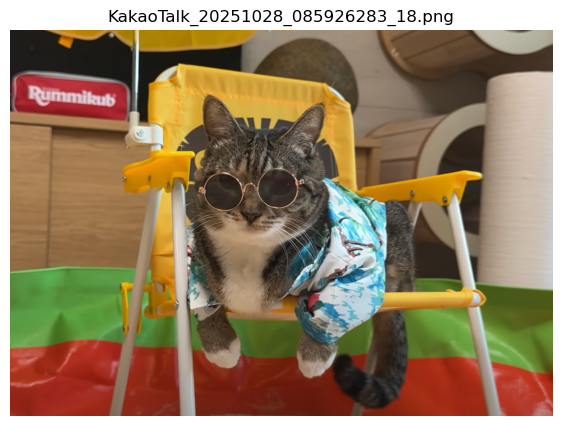

========== 결과 ==========
객체 태그 3개: #tabby, #Egyptian_cat, #tiger_cat
장소 태그 3개: #playroom, #playground, #ball_pit
분위기 태그 3개: #relaxed, #joyful, #cool
--------------------------------
카테고리 Top-3 (섞인 점수):
 - 동물: 32.8%
 - 산업: 11.5%
 - 예술: 11.5%


In [10]:
# ===============================
# Cell 9. 실제 실행 & 출력
# ===============================
TEST_IMG = "./test//KakaoTalk_20251028_085926283_18.png"   # 여기에 예측할 이미지 경로 넣으세요

res = run_full_infer(TEST_IMG)

# 이미지 보여주기
pil = Image.open(res["image"]).convert("RGB")
plt.figure(figsize=(7,7))
plt.imshow(pil)
plt.axis("off")
plt.title(Path(res["image"]).name, fontsize=12)
plt.show()

# 결과 출력
print("========== 결과 ==========")
print("객체 태그 3개:", ", ".join(res["objects"]))
print("장소 태그 3개:", ", ".join(res["scenes"]))
print("분위기 태그 3개:", ", ".join(res["moods"]))
print("--------------------------------")
print("카테고리 Top-3 (섞인 점수):")
for name, p in res["categories"]:
    print(f" - {name}: {p*100:.1f}%")
print("================================")
